# 0. Install and Import Dependencies

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
# import imageio
import dlib as dlib
import sys
from jiwer import cer
# import datetime

2023-11-25 09:52:17.959209: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-25 09:52:17.975828: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 09:52:17.975843: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-25 09:52:17.975858: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 09:52:17.979762: I tensorflow/core/platform/cpu_feature_g

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-11-25 09:52:19.325706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2023-11-25 09:52:19.327925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 09:52:19.328000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [49]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/home/somkiat/Lip_reading/package/shape_predictor_68_face_landmarks.dat')

In [4]:
vocab = [x for x in "กขฃคฅฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรลวศษสหฬอฮๆะาิีึืใไเแ่้็๊๋โฤ์ฯุูำั123456789"]
len(vocab)

77

In [5]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, mask_token=None, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, oov_token="", invert=True)

print(f"The vocabulary is: {char_to_num.get_vocabulary()} ")
print(f"(size ={char_to_num.vocabulary_size()})")

The vocabulary is: ['', 'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ๆ', 'ะ', 'า', 'ิ', 'ี', 'ึ', 'ื', 'ใ', 'ไ', 'เ', 'แ', '่', '้', '็', '๊', '๋', 'โ', 'ฤ', '์', 'ฯ', 'ุ', 'ู', 'ำ', 'ั', '1', '2', '3', '4', '5', '6', '7', '8', '9'] 
(size =78)


2023-11-25 09:52:28.012341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 09:52:28.012446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 09:52:28.012500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
def load_video(path):
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame_crop = frame
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame)
        #frames.append(frame[y:y+h,x:x+w,:])

    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std


def load_alignments(path):
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[0:]


def load_data(path: str):
    path = bytes.decode(path.numpy())
    path = path[::-1]
    dot = path.index(".")
    path = path[dot+1:]
    path = path.split('/')[0]
    file_name = path[::-1]

    # video_path = os.path.join('/home','somkiat','Lip_reading','data','s1',f'{file_name}.mp4')
    # alignment_path = os.path.join('/home','somkiat','Lip_reading','data','alignments','s1',f'{file_name}.align')
    video_path = os.path.join('/home','somkiat','Lip_reading','data-20-11','s1',f'{file_name}.mp4')
    alignment_path = os.path.join('/home','somkiat','Lip_reading','data-20-11','alignments','s1',f'{file_name}.align')


    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [9]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path],  (tf.float32, tf.int64))
    if len(result[1]) > 78:
        tf.print(path)
    return result

# 2. Create Data Pipeline

In [12]:
# data = tf.data.Dataset.list_files('/home/somkiat/Lip_reading/data/s1/*.mp4')
data = tf.data.Dataset.list_files(f'../data-20-11/s1/*.mp4')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
print('original data : ', (tf.data.experimental.cardinality(data).numpy()))
# for batch in data:
#     try:
#         tensor1, tensor2 = batch
#         if  tensor2.shape[0] > 78:
#             print(tensor2.shape[0])
#     except cv2.error as e:
#         print(f"OpenCV Error: {e}")
data = data.padded_batch(2, padded_shapes=([200,None, None,None],[79]), drop_remainder=True)
print('padded data : ', (tf.data.experimental.cardinality(data).numpy()))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split train  & train
train = data.take(500)
#test = data.skip(100)
test = data.skip(500)
train_length = tf.data.experimental.cardinality(train).numpy()

# Get the length of the `test` dataset
test_length = tf.data.experimental.cardinality(test).numpy()

print("Length of train dataset:", train_length)
print("Length of test dataset:", test_length)

original data :  1319
padded data :  659
Length of train dataset: 500
Length of test dataset: 159


In [9]:
train_length = tf.data.experimental.cardinality(train).numpy()

# Get the length of the `test` dataset
test_length = tf.data.experimental.cardinality(test).numpy()

print("Length of train dataset:", train_length)
print("Length of test dataset:", test_length)

Length of train dataset: 16000
Length of test dataset: 2030


In [10]:
frames, alignments = data.as_numpy_iterator().next()

In [11]:
test2 = data.as_numpy_iterator()

In [12]:
val = test2.next(); val[0]

array([[[[[3.1386685],
          [3.1386685],
          [3.1386685],
          ...,
          [3.1386685],
          [3.1386685],
          [3.1386685]],

         [[3.1386685],
          [3.1386685],
          [3.1386685],
          ...,
          [3.1386685],
          [3.1386685],
          [3.1386685]],

         [[3.1386685],
          [3.1386685],
          [3.1386685],
          ...,
          [3.1386685],
          [3.1386685],
          [3.1386685]],

         ...,

         [[3.1386685],
          [3.1386685],
          [3.1386685],
          ...,
          [3.1386685],
          [3.1386685],
          [3.1386685]],

         [[3.1386685],
          [3.1386685],
          [3.1386685],
          ...,
          [3.1386685],
          [3.1386685],
          [3.1386685]],

         [[3.1386685],
          [3.1386685],
          [3.1386685],
          ...,
          [3.1386685],
          [3.1386685],
          [3.1386685]]],


        [[[3.1386685],
          [3.1386685],
       

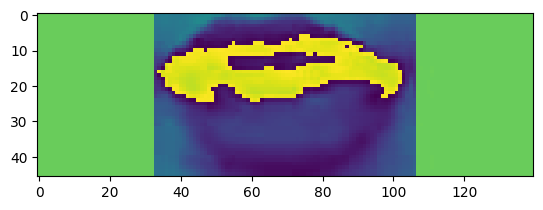

In [ ]:
plt.imshow(val[0][0][0])

# 3. Design the Deep Neural Network

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [14]:
data.as_numpy_iterator().next()[0][0].shape

(200, 46, 140, 1)

In [17]:
model = Sequential()
#model.add(Conv3D(128, 3, input_shape=(75,,None,1), padding='same'))
model.add(Conv3D(128, 3, input_shape=(200, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(200, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 200, 46, 140, 12   3584      
                             8)                                  
                                                                 
 activation (Activation)     (None, 200, 46, 140, 12   0         
                             8)                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 200, 23, 70, 128   0         
 D)                          )                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 200, 23, 70, 256   884992    
                             )                                   
                                                                 
 activation_1 (Activation)   (None, 200, 23, 70, 256   0

In [ ]:
val[0].shape

(2, 200, 46, 140, 1)

In [ ]:
yhat = model.predict(val[0])

2023-11-20 13:44:49.254067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-20 13:44:49.360022: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 3s 3s/step


# 4. Setup Training Options and Train

In [14]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [15]:
def CTCLoss(y_true, y_pred):

    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    #ignore_longer_outputs_than_inputs=True
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
#checkpoint_callback1 = ModelCheckpoint('/home/somkiat/Lip_reading/checkpoint_1/checkpoint.h5', monitor='loss')
checkpoint_callback = ModelCheckpoint('/home/somkiat/Lip_reading/checkpoint_1/checkpoint', monitor='val_loss',save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
from tensorflow import keras
class LossHistoryAndSave(keras.callbacks.Callback):
    def __init__(self, file_path):
        super().__init__()
        self.losses = []
        self.val_losses = []
        self.file_path = file_path

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        # Save loss values to a file
        with open(self.file_path, 'a') as file:
            file.write(f'Epoch {epoch + 1}: Training Loss: {logs.get("loss")}, Validation Loss: {logs.get("val_loss")}\n')

In [ ]:
loss_file_path = '/home/somkiat/Lip_reading/loss_log/loss_history.txt'
# Create an instance of the custom callback
loss_history_and_save = LossHistoryAndSave(loss_file_path)

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/home/somkiat/Lip_reading/logs")

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [200,200], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
model.fit(train, validation_data=test, epochs=100, batch_size=64, callbacks=[example_callback, early_stopping, tensorboard_callback, loss_history_and_save, checkpoint_callback, schedule_callback])

Epoch 1/100


16000/16000 [==============================] - ETA: 0s - loss: 105.0435

2023-11-20 16:32:31.686843: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: FileNotFoundError: [Errno 2] No such file or directory: '/home/somkiat/Lip_reading/data/alignments/s1/290-ซึ่งพอออกมาแล้วเนี่ยนะคะ เหล่าพี่น้องของซุสเนี่ยก็ไม่ได้ออกมาเป็นเด็กแบเบาะนะคะ.align'
Traceback (most recent call last):

  File "/home/somkiat/miniconda3/envs/LipNet_3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/home/somkiat/miniconda3/envs/LipNet_3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/home/somkiat/miniconda3/envs/LipNet_3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/home/somkiat/miniconda3/envs/LipNet_3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} FileNotFoundError: [Errno 2] No such file or directory: '/home/somkiat/Lip_reading/data/alignments/s1/290-ซึ่งพอออกมาแล้วเนี่ยนะคะ เหล่าพี่น้องของซุสเนี่ยก็ไม่ได้ออกมาเป็นเด็กแบเบาะนะคะ.align'
Traceback (most recent call last):

  File "/home/somkiat/miniconda3/envs/LipNet_3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/home/somkiat/miniconda3/envs/LipNet_3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/home/somkiat/miniconda3/envs/LipNet_3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/home/somkiat/miniconda3/envs/LipNet_3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_102178/593264020.py", line 42, in load_data
    alignments = load_alignments(alignment_path)

  File "/tmp/ipykernel_102178/593264020.py", line 19, in load_alignments
    with open(path, 'r', encoding='utf-8') as f:

  File "/home/somkiat/miniconda3/envs/LipNet_3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 286, in _modified_open
    return io_open(file, *args, **kwargs)

FileNotFoundError: [Errno 2] No such file or directory: '/home/somkiat/Lip_reading/data/alignments/s1/290-ซึ่งพอออกมาแล้วเนี่ยนะคะ เหล่าพี่น้องของซุสเนี่ยก็ไม่ได้ออกมาเป็นเด็กแบเบาะนะคะ.align'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

# 5. Make a Prediction

In [ ]:
#url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
#output = 'checkpoints.zip'
#gdown.download(url, output, quiet=False)
#gdown.extractall('checkpoints.zip', 'models')

In [ ]:
# from tensorflow.keras.optimizers import legacy

# # define your optimizer as a legacy optimizer
# optimizer = legacy.Adam()

# model.compile(optimizer=optimizer)

In [18]:
# model.load_weights('/home/somkiat/Lip_reading/checkpoint_1/checkpoint')
model.load_weights(f'../data/checkpoint_1/checkpoint')

In [19]:
test_data = test.as_numpy_iterator()

In [20]:
sample = test_data.next()

In [23]:
eva_true = []
eva_pred = []
for sample in test_data:
    try:
        for i in range(0, 2):
            y_true = []
            for j in sample[1][i]:
                if j != 0:
                    y_true.append(j)
            yhat = model.predict(sample[0])
            eva_true.append(''.join([string.decode('utf-8') for string in num_to_char(y_true).numpy()]))                                                                                      
            y_pred = []
            for k in yhat[i]:
                sorted_array = np.sort(k)[::-1]
                # Get the fifth largest value
                top_five_indices = np.argsort(k)[-5:]

                # Replace values not in the top five with 0
                result_array = np.where(np.isin(np.arange(len(k)), top_five_indices), k, 0)
                top_five_indices = np.argsort(result_array)[-5:]
                result_array = np.zeros(np.max(top_five_indices) + 1)
                result_array[top_five_indices] = top_five_indices  # Y
                result_array = result_array[result_array != 0]
                top_five = []
                for x in result_array:
                    top_five.append(x)
                y_pred.append(top_five)
            top_one = []
            for m in range(0, len(y_true)):
                if y_true[m] in y_pred[m]:
                    top_one.append(y_true[m])
                else:
                    # top_one.append(max)
                    top_one.append(79)
            eva_pred.append(''.join([string.decode('utf-8') for string in num_to_char(top_one).numpy()]))
    except:
        pass

2023-11-25 10:01:11.677306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-25 10:01:11.715210: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-25 10:01:11.770591: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-25 10:01:11.770614: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-25 10:01:11.770626: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate

1/1 [==============================] - 0s 54ms/step


In [24]:
eva_pred

['แล้ว็นการัาน',
 'แล้วเมงไกน',
 'ใราน',
 'นแา',
 'ใ้น่อง',
 'น้องเป็นแ',
 'กรัะค',
 'ะ่นาค',
 'เาะวก็อคิ',
 'แต่รายะัััง่',
 'งมกา',
 'น',
 'งก',
 'ัอยาน',
 'แก้อนจั',
 'แต่วรก',
 'แั',
 'แา',
 'ี',
 'เกิัน',
 'ราร',
 'กัก',
 'เะกเอกกกนนกายริง',
 'วมา',
 'นทกันเย',
 'เาั่มัน',
 'ัใก้ม',
 'นูน',
 'ั่ัรเรื่อง',
 'วใัเมน',
 '่ารก',
 '',
 '่เกมนงเนี่',
 'าง',
 'งงเป็นน',
 'เล่ยแนั่',
 'ไม่ระ',
 'นะ',
 '็ก',
 '',
 'เาะ้กน่า',
 'เ่่อ่งไ',
 'ร',
 'ียนเ',
 'ยาไ้ย',
 'แตรวเร็',
 'เ็นที่',
 'น',
 'กอะไร',
 'ง',
 'น่ค',
 'แต่กนมั่ายบ',
 'แล้วกว',
 'นากเ',
 'เีวาน',
 'แต่วระแกกน',
 'แล้วเมานน',
 'เ้าเนะค',
 'ใร่',
 'แต่ว',
 'เ็นักาา',
 'าวย',
 'ันี้ะ',
 'ไมแที่แล',
 'เาะ้อะไราย',
 'นเ',
 'เงารืมีแ',
 'นะ',
 'แต็นก',
 'แลวเนี่มร',
 'ะ',
 'ยน',
 'เาะวั่มานแนนก',
 'าอย',
 'าา',
 'าเไมกน',
 'ั',
 'กเ',
 'เนงค',
 'แตกวะ',
 'ะูค',
 'แ่างเ',
 'แลวากกาน',
 'แล้วเ็มีอไิาง',
 'แนน่',
 'เ็นว',
 'น',
 'าินบ่อ',
 'ะมี',
 'กับอ',
 'ไัวะ',
 'ะน',
 'แล้วค',
 'เ่า',
 'ะ',
 '่ะก',
 'แลกยไมรร',
 '่ทกนก',
 'ะราอา',


In [25]:
print(len(eva_true))
print(len(eva_pred))

314
314


In [28]:
eva = []
for i in range(0, len(eva_true)):
    error = cer(eva_true[i], eva_pred[i])
    eva.append(error)
# Print the result
print(f"Average Char Error Rate: {sum(eva) / len(eva)}")

Average Char Error Rate: 0.828020037906062


In [ ]:
# y_true = [string.decode('utf-8') for string in num_to_char(y_true).numpy()]
# y_pred = [string.decode('utf-8') for string in num_to_char(top_one).numpy()]

In [83]:
import pandas as pd

# Creating a DataFrame
df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})

# Display the DataFrame
print(df.head(29))

ValueError: All arrays must be of the same length

In [ ]:
# yhat = model.predict(sample[0])
# for i in yhat:
#     index = i[81]
#     sorted_array = np.sort(index)[::-1]
#     # Get the fifth largest value
#     top_five_indices = np.argsort(index)[-5:]

#     # Replace values not in the top five with 0
#     result_array = np.where(np.isin(np.arange(len(index)), top_five_indices), index, 0)
#     top_five_indices = np.argsort(result_array)[-5:]
#     print(top_five_indices)
#     result_array = np.zeros(max(top_five_indices) + 1)
#     result_array[top_five_indices] = top_five_indices  # Y
#     result_array = result_array[result_array != 0]
#     for i in result_array:
#         print(int(i))
    

In [ ]:
# result_array

In [ ]:
# decoded = tf.keras.backend.ctc_decode(result_array, input_length=[200,200], greedy=True).numpy()

In [ ]:
# yhat = model.predict(sample[0])
# print(np.argmax(yhat[0][0]))
# print('~'*100, 'REAL TEXT')
# tf.print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]])
# decoded = tf.keras.backend.ctc_decode(yhat, input_length=[200,200], greedy=True)[0][0].numpy()
# print('~'*100, 'PREDICTIONS')
# tf.print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded])  
# print(decoded[0])

1/1 [==============================] - 0s 56ms/step
78
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
["ความเกิดจากนี้", "หรือบางทีดูชื่อเว็บไซต์อย่างเดียวไม่พอค่ะ"]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
["ะ", ""]
[46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]


In [ ]:
# #sample = test_data.next()
# for sample in test_data:
#     yhat = model.predict(sample[0])
#     print('~'*100, 'REAL TEXT')
#     tf.print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]])
#     decoded = tf.keras.backend.ctc_decode(yhat, input_length=[200,200], greedy=True)[0][0].numpy()
#     print('~'*100, 'PREDICTIONS')
#     tf.print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded])    

In [ ]:
# print('~'*100, 'REAL TEXT')
# tf.print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]])

In [ ]:
# decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
# print('~'*100, 'PREDICTIONS')
# tf.print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded])

# Test on a Video

In [ ]:
#sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
# print('~'*100, 'REAL TEXT')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
# yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
# decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
# print('~'*100, 'PREDICTIONS')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]